# Task 1

In [216]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv("matches.csv")
data = data[data.league_id == 148]
data = data[['match_hometeam_score', 'match_awayteam_score']]
mean_home= data['match_hometeam_score'].mean()
mean_away= data['match_awayteam_score'].mean()
number_of_games = data['match_hometeam_score'].size
print(number_of_games)
print(mean_home)

618
1.6019417475728155


(array([127, 197, 158,  78,  43,  10,   2,   2], dtype=int64), array([0., 1., 2., 3., 4., 5., 6., 7., 8.]))


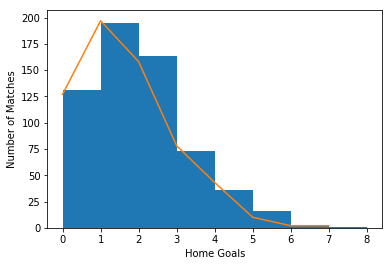

In [217]:
#first plot
#possible to calculate number of mins via min and max goal numbers and linspace
plt.figure()
plt.hist(data['match_hometeam_score'], bins=8)
histogram = np.histogram(np.random.poisson(lam=mean_home, size= number_of_games), bins=8, range=(0,8))
print(histogram)
plt.plot(histogram[0])
plt.xlabel('Home Goals')
plt.ylabel('Number of Matches')
plt.show()




(array([185, 221, 132,  50,  21,   8], dtype=int64), array([0., 1., 2., 3., 4., 5., 6.]))


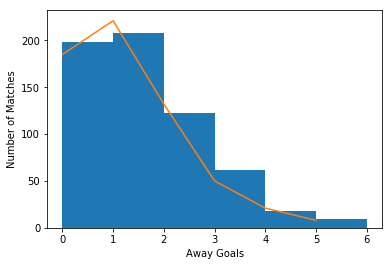

In [218]:
#second plot
plt.figure()
plt.hist(data['match_awayteam_score'], bins= 6)
histogram = np.histogram(np.random.poisson(lam=mean_away, size= number_of_games), bins=6, range=(0,6))
print(histogram)
plt.plot(histogram[0])
plt.xlabel('Away Goals')
plt.ylabel('Number of Matches')
plt.show()

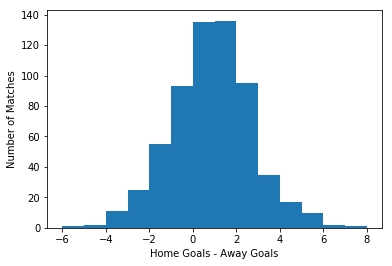

In [219]:
#third plot
plt.figure()
plt.hist(data['match_hometeam_score'] - data['match_awayteam_score'], bins= 14)
plt.xlabel('Home Goals - Away Goals')
plt.ylabel('Number of Matches')
plt.show()

In [220]:
for i in range(2,6):
        print(i)


2
3
4
5


# Task 2


In [221]:
bets = pd.read_csv("bets.csv")
matches = pd.read_csv("matches.csv")
combined = pd.merge(bets,matches[['match_id','league_id','match_hometeam_score', 'match_awayteam_score']])
combined = combined[combined.league_id == 148]
#check if there are any duplicate rows
duplicate_rows = combined[combined.duplicated()]
#result : there are no duplicate rows



In [289]:
#pick a bookmaker
Bookmaker1 = combined[combined.odd_bookmakers == "10Bet"]

#only get the relevant informatiom
Bookmaker1 = Bookmaker1[Bookmaker1.variable.isin(["odd_1", "odd_2", "odd_x"])]

#calculate the probabilities
Bookmaker1['probability'] = Bookmaker1.apply(lambda row: (1/(row['value'])), axis=1)

#normalize the probabilities
Bookmaker1['probability_sum'] = Bookmaker1.groupby(['odd_epoch', 'match_id'])[['probability']].transform(sum)
Bookmaker1['normalized_probability'] = Bookmaker1.apply(lambda row: (row['probability']/row['probability_sum']), axis=1)

#check if the result of the game is draw
Bookmaker1['Draw?'] = np.where((Bookmaker1['match_hometeam_score'] - Bookmaker1['match_awayteam_score']) == 0, 'Yes', 'No')
Bookmaker1 = Bookmaker1.sort_values([('match_id')], ascending = True)

#create a new bookmaker dataframe based on relevant data
Bookmaker1_new= Bookmaker1[['match_id', 'odd_epoch', 'Draw?']]
Bookmaker1_new = Bookmaker1_new.drop_duplicates()



In [288]:
#create a pivot table to get the difference between homewin and awaywin, 
newtable = Bookmaker1.pivot_table(index = ['odd_epoch', 'match_id'], columns = 'variable', values= 'normalized_probability')
newtable['Phome_minus_Paway'] = newtable['odd_1'] - newtable['odd_2']

#calculate the bins and sort the bins in an ascending way
binvalues = np.arange(-1,1,0.05,dtype=None)
newtable['binned'] = pd.cut(newtable['Phome_minus_Paway'], binvalues)
newtable = newtable.sort_values([('match_id')], ascending = True)

#for easier calculation and manipulation, get the values from the pivot table and turn them into numpy arrays in the same order
diff_array = newtable['Phome_minus_Paway']
diff_array = np.array(diff_array)
draw_array = newtable['odd_x']
draw_array = np.array(draw_array)

#add the arrays into the data frame 
Bookmaker1_new['prob_dif'] = diff_array
Bookmaker1_new['draw_prob'] = draw_array

Bookmaker1_new['binned'] = pd.cut(Bookmaker1_new['prob_dif'], binvalues)

Bookmaker1_new = Bookmaker1_new.sort_values(['binned'])
totalcount = Bookmaker1_new.groupby('binned').count().prob_dif
drawcount = Bookmaker1_new.groupby('binned')['Draw?'].apply(lambda x: (x == 'Yes').sum()).reset_index(name='draw_count')
totalcount = totalcount.to_frame()
Bookmaker1_new
# take the average of the 
bookmaker_bet_draw_average = Bookmaker1_new.groupby('binned').mean().draw_prob
bookmaker_bet_draw_average = bookmaker_bet_draw_average.to_frame() 
bookmakers_draw_average_array = np.array(bookmaker_bet_draw_average['draw_prob'])
bookmakers_draw_average_array
binned_array = np.array(Bookmaker1_new['binned'])




In [324]:



draw_numbers = np.array(drawcount['draw_count'])
totalcount['draw'] = draw_numbers

def calc_observed(row):
    if row['prob_dif'] == 0:
        val = 0
    else:
        val = row['draw'] / row['prob_dif']
    return val

totalcount['observed_prob'] = totalcount.apply(calc_observed, axis=1)
#
totalcount['bookmakers_draw_average'] = bookmakers_draw_average_array

binned = np.array([(-1.0, -0.95),(-0.95, -0.9),(-0.9, -0.85),(-0.85, -0.8),(-0.8, -0.75),(-0.75, -0.7), (-0.7, -0.65), 
                   (-0.65, -0.6),(-0.6, -0.55),(-0.55, -0.5), (-0.5, -0.45), (-0.45, -0.4), (-0.4, -0.35), (-0.35, -0.3), 
                   (-0.3, -0.25), (-0.25, -0.2), (-0.2, -0.15), (-0.15, -0.1), (-0.1, -0.05), (-0.05, 0), (0, 0.05), (0.05,0.1),
                  (0.1,0.15),(0.15,0.2), (0.2,0.25), (0.25,0.3), (0.3,0.35), (0.35,0.4), (0.4,0.45), (0.45, 0.5)
                  , (0.5,0.55), (0.55,0.6), (0.6,0.65), (0.65, 0.7), (0.7,0.75), (0.75, 0.8), (0.8,0.85), (0.85,0.9), (0.9,0.95)
                  ])

deneme = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])

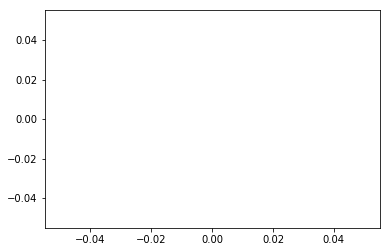

In [330]:
plot = plt.plot(x= deneme, y = totalcount['observed_prob'], color = 'red')
plt.xlim = ([1,30])

In [275]:
#def turn_NaN_into_0(row):
 #   if row['bookmakers_draw_average'] == "NaN" :
  #      row['bookmakers_draw_average'] = 0
#totalcount = totalcount.apply(turn_NaN_into_0, axis =1)        
#totalcount
#In [1]: df['C'] = df.apply(f, axis=1)
#totalcount['observed_probability'] = totalcount
#gapminder['gdpPercap_ind'] = gapminder.gdpPercap.apply(lambda x: 1 if x >= 1000 else 0)
#dfObj = dfObj.assign(Percentage =lambda x: (x['Marks'] / x['Total'] ) * 100)

#final = totalcount.binned

#totalcount
#result
#totalcount = np.array(totalcount)
#totalcount
#plt.hist(data, bins=np.arange(min(data), max(data) + binwidth, binwidth))
#plot = plt.hist(totalcount['prob_dif'] , bins=np.arange(-1,1,0.05))